In [1]:
rm(list=ls())

#Se utiliza pacman para instalar y cargar paquetes
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse,
               webshot2,
               showtext,
               magick,
               gt,
               scales)



Cargando paquete requerido: pacman



In [2]:
font_add_google("Roboto", "rob")
showtext_auto()

paleta_ipdp <- c("#9F2241",
                 "#BC955C",
                 "#AC6D14",
                 "#799B48",
                 "#E02B75",
                 "#F08217",
                 "#f5aeb8",
                 "#de7aaf",
                 "black",
                 "#e5074c",
                 "#73cae6",
                 "#266cb4",
                 "#027A35")

In [3]:
#Función para crear tabla
###Si existe algún problema al momento del output de la función crea_tabla, correr remotes::install_github("rstudio/chromote")

crea_tabla <- function(df, titulo, subtitulo,nota="",nombre_archivo){

  # Format the numeric columns with commas
  formatted_df <- df #|>
    #mutate(across(where(is.numeric), ~scales::comma(.)))

  # Checa si existe la columna "Organismo" para agrupar la tabla
  if("Organismo" %in% names(df)) {
    gt_table <- formatted_df |>
      gt(rowname_col = "Organismo",
         groupname_col = "Año",
         row_group_as_column = TRUE)
  } else {
    gt_table <- formatted_df |>
      gt()
  }

  gt_table <- gt_table |>
    tab_options(
      column_labels.font.weight = "bold",
    ) |>
    tab_header(
      title = md(paste0("**", titulo, "**")),
      subtitle=md(paste0("*", subtitulo, "*"))
    ) |>
    tab_options(
      table.font.names = 'Roboto',
      source_notes.font.size = 8,
      table.border.top.width = px(0),
      table.border.bottom.width = px(0),
      column_labels.background.color = "#9F2241",
      column_labels.font.size = 10,
    heading.title.font.size = 15,
    ) |>
    cols_align(
      align = "center"
    ) |>
    tab_source_note(
      source_note = md("")
    ) |>
    tab_source_note(
      source_note = md(nota)
    ) |>
    tab_source_note(
      source_note = md("")
    )|>
    cols_width(
      everything() ~ px(180)
    )

  # Salva la tabla
  gtsave(gt_table, filename = nombre_archivo)

  # Muestra la imagen
  img <- image_read(nombre_archivo)
  return(img)
}

In [4]:
ingresos_cdmx <- read_csv("https://datos.cdmx.gob.mx/dataset/f04b7092-782d-4206-9590-ac8b577891dc/resource/77c2e268-f5b4-4cdf-a705-13a73a9608b3/download/ingresos_2024_01.csv", 
                          col_types = NULL)

Rows: 2281 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): periodo, desc_tipo_recurso_clase, desc_rubro, desc_tipo, clase, de...
dbl  (6): ciclo, tipo_recurso_clase, rubro, tipo, monto_estimado, monto_reca...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
#MONTO TOTAL DE INGRESOS RECAUDADOS
recaudados_por_ciclo <- ingresos_cdmx|>
  filter(periodo == "Anual")|>
  group_by(ciclo)|>
  summarise(montoest = sum(monto_estimado, na.rm = TRUE)/1000000)|>
  mutate(var = round((montoest/lag(montoest, 1)-1)*100,1), 
         var = as.character(var),
         var = case_when(is.na(var) ~ "-",
          TRUE ~ var))|>
  rename(`Monto estimado`=montoest,
         `Año` = ciclo, 
         `Var. porcentual`= var)|>
  mutate(`Monto estimado` = format(`Monto estimado`, big.mark = ",", decimal.mark = "."))

   

recaudados_por_ciclo


Año,Monto estimado,Var. porcentual
<dbl>,<chr>,<chr>
2018,"226,851.9",-
2019,"234,016.3",3.2
2020,"238,975.8",2.1
2021,"217,962.2",-8.8
2022,"234,000.9",7.4
2023,"248,415.1",6.2
2024,"267,965.4",7.9


file:///C:/Users/brenp/AppData/Local/Temp/RtmpgfV1ts/file62801b987249.html screenshot completed



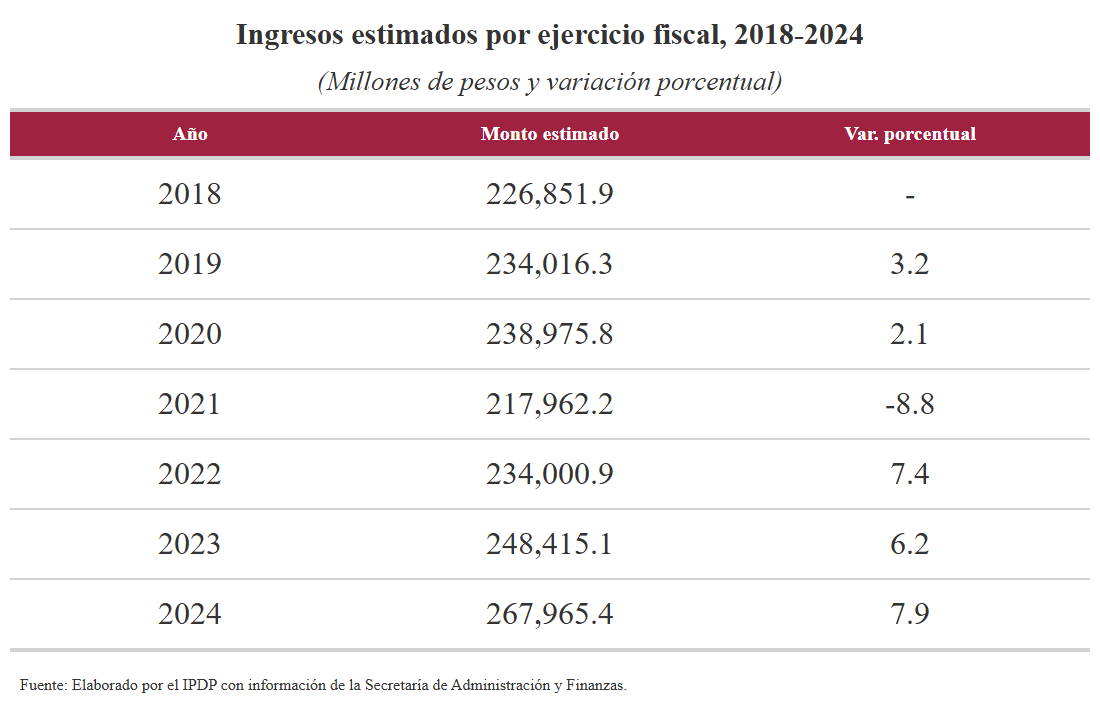

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG     1100    728 sRGB       FALSE    44084 72x72  

In [6]:
crea_tabla(recaudados_por_ciclo,"Ingresos estimados por ejercicio fiscal, 2018-2024","(Millones de pesos y variación porcentual)","Fuente: Elaborado por el IPDP con información de la Secretaría de Administración y Finanzas.","tabla_ingresos.png")

In [7]:
#MONTO TOTAL DE INGRESO RECAUDADO POR TIPO DE INGRESO
recaudados_por_ciclo_por_clase <- ingresos_cdmx |>
  filter(periodo == "Anual") |>
  group_by(ciclo, desc_tipo_recurso_clase) |>
  summarise(montoest = sum(monto_estimado, na.rm = TRUE) / 1000000) |>
  mutate(pct = round(((montoest * 100) / sum(montoest)), 1))|>
  rename(
         clase = desc_tipo_recurso_clase) |>
  mutate(clase = case_when(
    clase == "Ingresos del Sector Paraestatal" ~ "Sector Paraestatal",
    clase == "Ingresos locales" ~ "Locales",
    TRUE ~ clase
  )) |>
  ungroup() |>
  group_by(ciclo) |>
  #Ordenar los factores
  mutate(clase = fct_reorder(clase, pct, .desc = TRUE)) |>
  ungroup()

recaudados_por_ciclo_por_clase

`summarise()` has grouped output by 'ciclo'. You can override using the
`.groups` argument.


ciclo,clase,montoest,pct
<dbl>,<fct>,<dbl>,<dbl>
2018,Endeudamiento,5500.00,2.4
2018,Sector Paraestatal,15981.90,7.0
2018,Locales,91886.01,40.5
2018,Recursos federales,113483.99,50.0
2019,Endeudamiento,5500.00,2.4
2019,Sector Paraestatal,16344.70,7.0
2019,Locales,92762.95,39.6
2019,Recursos federales,119408.68,51.0
2020,Endeudamiento,4000.00,1.7


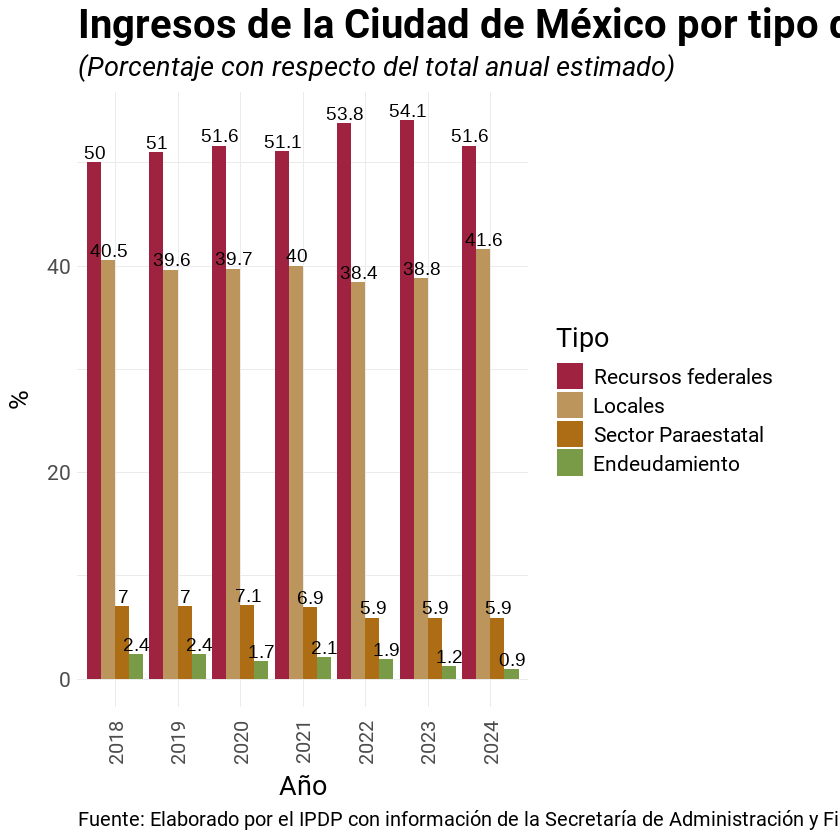

In [8]:
# Gráfica
recaudados_por_ciclo_por_clase|>
ggplot(aes(x = factor(ciclo), y = pct, fill = clase)) +
  geom_col(position = "dodge") +
  geom_text(aes(label = round(pct, 1)), position = position_dodge(width = 0.9), vjust = -0.3, size = 5, color = "black")+
  scale_fill_manual("Tipo",values = paleta_ipdp) +
  labs(
    title = "Ingresos de la Ciudad de México por tipo de recurso, 2018-2024",
    subtitle = "(Porcentaje con respecto del total anual estimado)",
    x = "Año",
    y = "%",
    fill = "Tipo", 
    caption = "Fuente: Elaborado por el IPDP con información de la Secretaría de Administración y Finanzas"
  ) +
  theme_minimal() +
    theme(#axis.text.x = element_text(angle = 45, hjust = 1),
            plot.title = element_text(hjust = 0, size=30,face="bold"),
        legend.position = "right",
            plot.subtitle = element_text(hjust = 0, size=20, face="italic"),
            plot.caption = element_text(hjust = 0,size=15),
            axis.text.x = element_text(angle = 90, vjust = 0.5,size=15),
            text=element_text("rob",size=20))

ggsave("ingresos_por_tipo.png",width=15,height=8, dpi = 100, bg="white")

`summarise()` has grouped output by 'desc_tipo_recurso_clase'. You can override
using the `.groups` argument.
file:///C:/Users/brenp/AppData/Local/Temp/RtmpgfV1ts/file62807cc94225.html screenshot completed



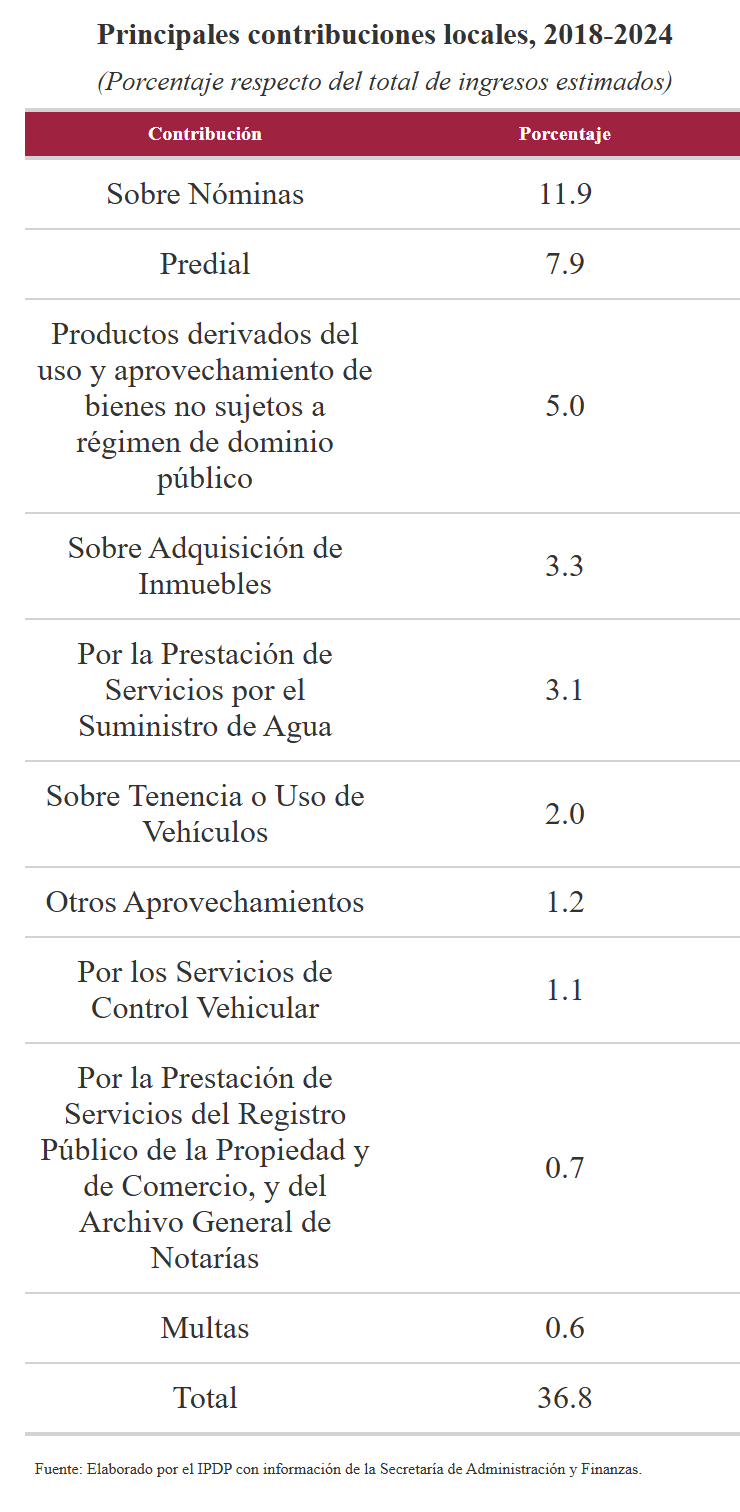

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG      740   1512 sRGB       FALSE   109650 72x72  

In [9]:
#PORCENTAJE DE PARTICIPACIÓN DE LOS INGRESOS LOCALES CON RESPECTO AL TOTAL DE LOS INGRESOS ANUALES
ingresos_cdmx |>
  filter(periodo == "Anual") |>
  group_by(desc_tipo_recurso_clase, desc_clase) |>
  summarise(montoest = sum(monto_estimado, na.rm = TRUE)/1000000)|> #Millones de pesos
  ungroup() |>
  #group_by(ciclo) |>
  mutate(porcentaje = round((montoest * 100) / sum(montoest), 1)) |>
  ungroup() |>
  filter(desc_tipo_recurso_clase == "Ingresos locales")|>
  select(desc_clase,porcentaje)|>
   slice_max(order_by = porcentaje, n = 10)|>
   rename(
    'Contribución'=desc_clase,
    'Porcentaje'=porcentaje 
   )|>
   janitor::adorn_totals()|>
crea_tabla("Principales contribuciones locales, 2018-2024","(Porcentaje respecto del total de ingresos estimados)","Fuente: Elaborado por el IPDP con información de la Secretaría de Administración y Finanzas.","princip_ingresos.png")

`summarise()` has grouped output by 'ciclo'. You can override using the
`.groups` argument.
file:///C:/Users/brenp/AppData/Local/Temp/RtmpgfV1ts/file628033a86132.html screenshot completed



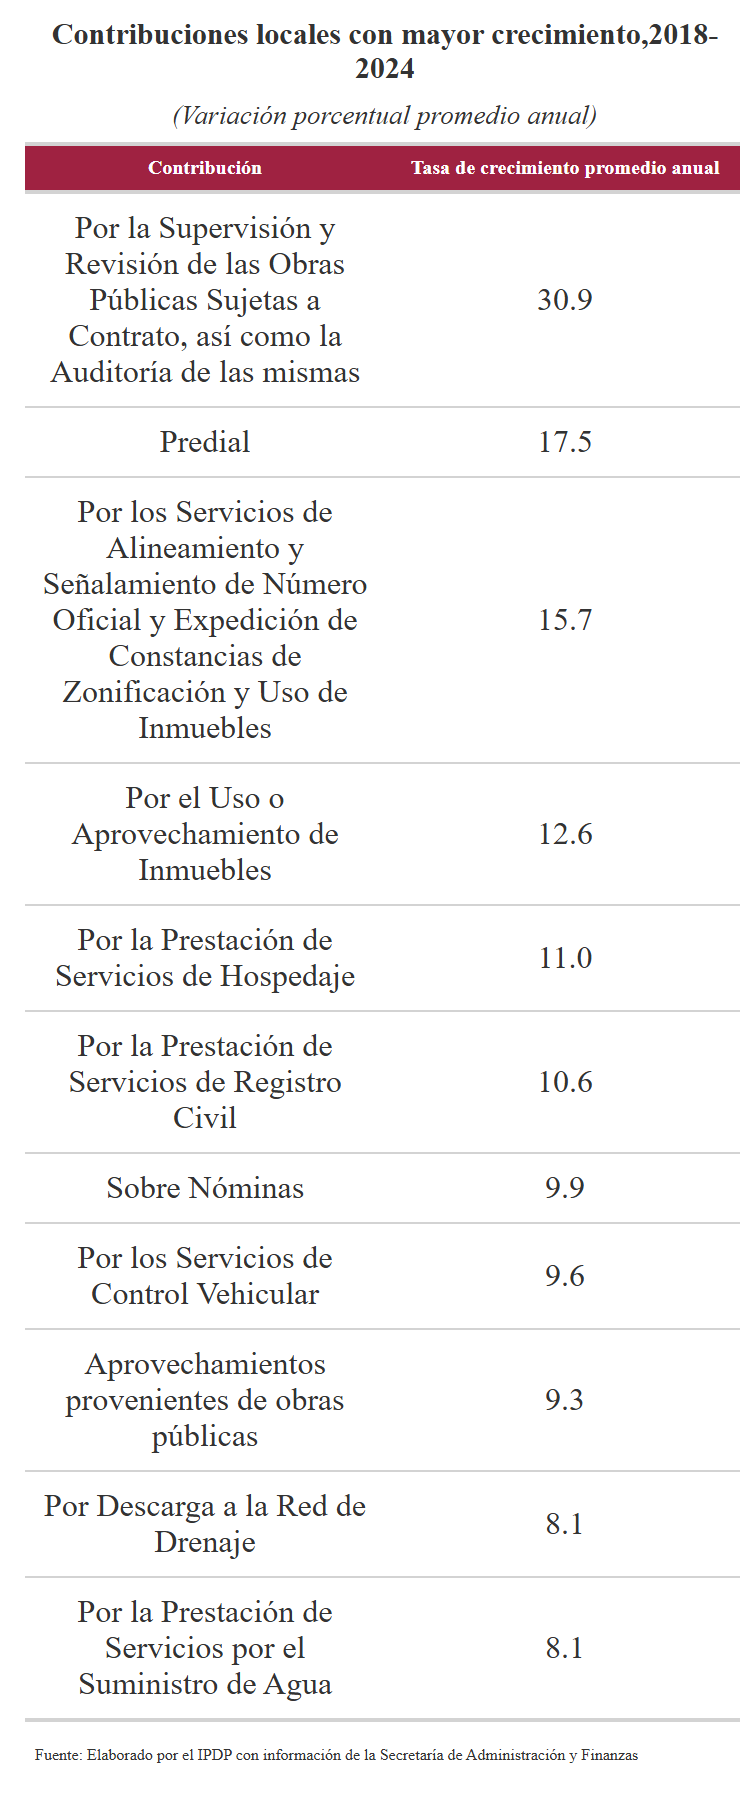

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG      740   1798 sRGB       FALSE   139319 72x72  

In [ ]:
#TCMA DE LOS INGRESOS LOCALES DESAGREGADO POR CLASE DEL INGRESO
ingresos_cdmx |>
  filter(ciclo %in% c(2018, 2024), 
         desc_tipo_recurso_clase == "Ingresos locales")|>
  select(ciclo, desc_clase, monto_estimado) |>
  group_by(ciclo, desc_clase) |>
  summarise(montoest = sum(monto_estimado, na.rm = TRUE)/1000000) |>
  pivot_wider(names_from = ciclo, values_from = montoest, names_prefix = "ciclo_") |>
  mutate(tcma = round(((ciclo_2024 / ciclo_2018)^(1/(2024-2018)) - 1) * 100,1)) |>
  arrange(desc(tcma))|>
  select(desc_clase,tcma)|>
  slice_max(order_by = tcma,n=10)|>
     rename(
    'Contribución'=desc_clase,
    'Tasa de crecimiento promedio anual'=tcma 
   )|>
   crea_tabla("Contribuciones locales con mayor crecimiento,2018-2024","(Variación porcentual promedio anual)", "Fuente: Elaborado por el IPDP con información de la Secretaría de Administración y Finanzas.","top_ingresos.png")
  

`summarise()` has grouped output by 'ciclo'. You can override using the
`.groups` argument.
file:///C:/Users/brenp/AppData/Local/Temp/RtmpgfV1ts/file62804a4a3b5.html screenshot completed



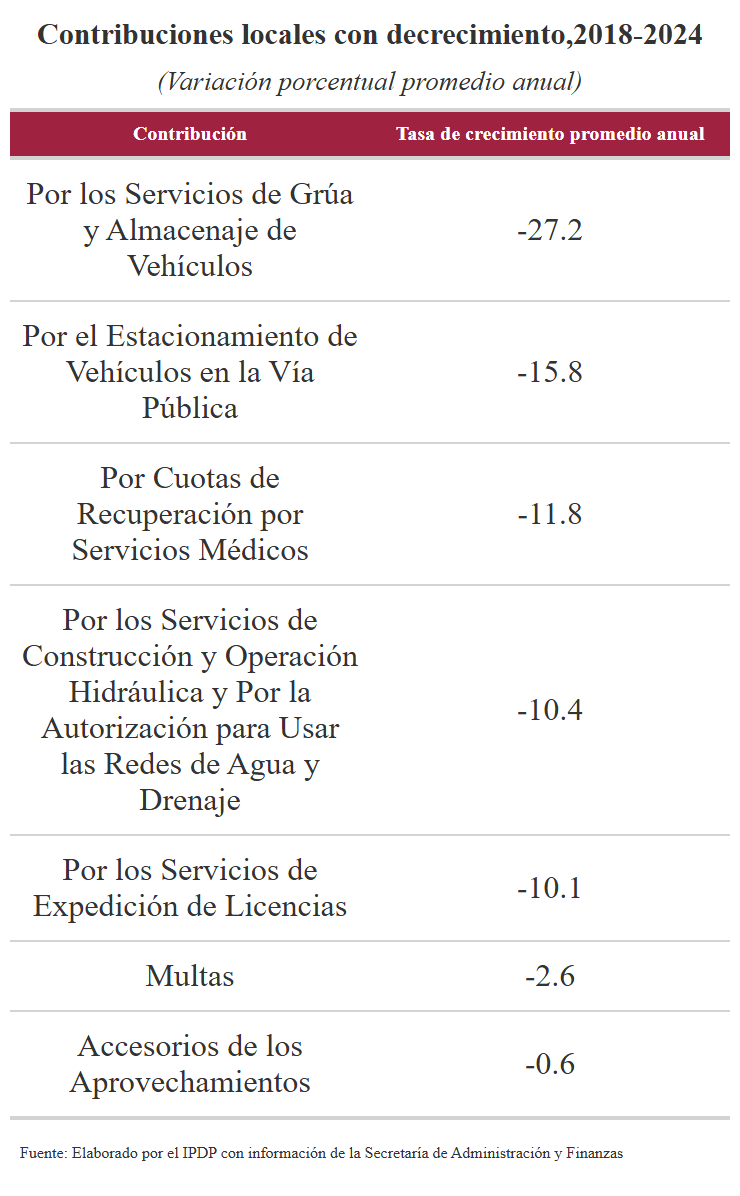

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG      740   1196 sRGB       FALSE    93578 72x72  

In [ ]:
#TCMA DE LOS INGRESOS LOCALES DESAGREGADO POR CLASE DEL INGRESO
ingresos_cdmx |>
  filter(ciclo %in% c(2018, 2024), 
         desc_tipo_recurso_clase == "Ingresos locales")|>
  select(ciclo, desc_clase, monto_estimado) |>
  group_by(ciclo, desc_clase) |>
  summarise(montoest = sum(monto_estimado, na.rm = TRUE)/1000000) |>
  pivot_wider(names_from = ciclo, values_from = montoest, names_prefix = "ciclo_") |>
  mutate(tcma = round(((ciclo_2024 / ciclo_2018)^(1/(2024-2018)) - 1) * 100,1)) |>
  arrange(desc(tcma))|>
  select(desc_clase,tcma)|>
filter(tcma>-100)|>
  slice_min(order_by = tcma,n=10)|>
filter(tcma<=0)|>
     rename(
    'Contribución'=desc_clase,
    'Tasa de crecimiento promedio anual'=tcma 
   )|>
   crea_tabla("Contribuciones locales con decrecimiento,2018-2024","(Variación porcentual promedio anual)", "Fuente: Elaborado por el IPDP con información de la Secretaría de Administración y Finanzas.","bottom_ingresos.png")
  